In [ ]:
import re
import nltk
import math
import string
import urllib

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential, load_model, model_from_json
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape

%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Academic/DM and ML/Comments.csv')
df

,comments,suspicious
0,রমজান মাস চলে গেছে এখন আর এসব দেখলে সমস্যা নাই...,1
1,"তোকে নিয়ে কিছু বলার নাই,",0
2,"দু সালা তরে জুতা মাড়ি শাকিব খান আছে ত ,",1
3,ক্ষমা চাওয়ার পর তাকে আর এটাক করা উচিত নয়।যেহেত...,0
4,ধন্যবাদ হিরো আলম ভাই কে দিককার যানাই মেসা এবং ...,0
...,...,...
25214,কুকুর কে দুধ দিয়ে গোচল দিলেও পায়খানায় মুখ দিবে।,1
25215,আমার দাড়াইয়া গেছেসুন্দর পরিবেশটা গরম হইয়া গেছে...,0
25216,আর শুধু ক্যারিয়ার বাঁচাতে বললে ভুল হবে। বাংলাদ...,1
25217,ওর পাছায় রিমান্ডে নিয়ে গরম ডিম থেরাপি দেওয়া উচ...,1


In [ ]:
df.isnull().sum()

comments      0
suspicious    0
dtype: int64

In [ ]:
df.shape

(25219, 2)

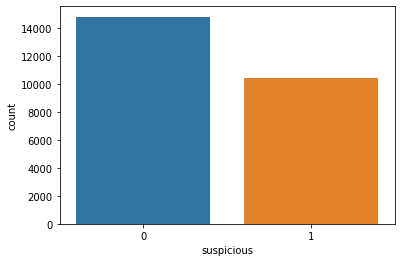

In [ ]:
sns.countplot(x="suspicious",data=df)

In [ ]:
transTable = str.maketrans({key: None for key in string.punctuation})
def remove_punc(s):
    return s.translate(transTable)

In [ ]:
x = df['comments'].fillna(' ')
y = df['suspicious']

In [ ]:
x = x.apply(remove_punc)

In [ ]:
# Format words and remove unwanted characters
whitespace = re.compile(u"[\s\u0020\u00a0\u1680\u180e\u202f\u205f\u3000\u2000-\u200a]+", re.UNICODE)
bangla_digits = u"[\u09E6\u09E7\u09E8\u09E9\u09EA\u09EB\u09EC\u09ED\u09EE\u09EF]+"
english_chars = u"[a-zA-Z0-9]"
punc = u"[(),$%^&*+={}\[\]:\"|\'\~`<>/,¦!?½£¶¼©⅐⅑⅒⅓⅔⅕⅖⅗⅘⅙⅚⅛⅜⅝⅞⅟↉¤¿º;-]+"
bangla_fullstop = u"\u0964"     #bangla fullstop(dari)
punctSeq   = u"['\"“”‘’]+|[.?!,…]+|[:;]+"
stopwords = pd.read_csv('/content/drive/MyDrive/Academic/DM and ML/stopwords-bn.txt')
def clean_text(x,remove_stopwords = True):
    x = re.sub(bangla_digits, " ", x)
    x = re.sub(punc, " ", x)
    x = re.sub(english_chars, " ", x)
    x = re.sub(bangla_fullstop, " ", x)
    x = re.sub(punctSeq, " ", x)
    x = whitespace.sub(" ", x).strip()
    
    x = re.sub(r'https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE)
    x = re.sub(r'\<a href', ' ', x)
    x = re.sub(r'&amp;‘:‘ ’', '', x) 
    x = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]। ,', ' ', x)
    x = re.sub(r'<br />', ' ', x)
    x = re.sub(r'\'', ' ', x)
    x = re.sub(r"[\@$#%~+-\.\'।\"]"," ",x)
    x = re.sub(r"(?m)^\s+", "", x)
    x = re.sub("[()]","",x)
    x = re.sub("[‘’]","",x)
    x = re.sub("[!]","",x)
    x = re.sub("[/]","",x)
    x = re.sub("[:]","",x)
    x = re.sub('\ |\?|\.|\!|\/|\;|\:', ' ',x)
    x = x.strip("/")
    
    if remove_stopwords:
        k = []
        for word in stopwords:
            word = word.split()
            k.append(word[0])
        x = [t for t in x if t not in k]
        x = "".join(x)

    return x

In [ ]:
vocab = CountVectorizer(analyzer=clean_text,encoding='utf-8').fit(x)

In [ ]:
x_vectorized = vocab.transform(x)

In [ ]:
print(vocab.get_feature_names())

[' ', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ৗ', 'ড়', 'ঢ়', 'য়', 'ৰ', 'ৱ', '৳', '৷']


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_vectorized,y,test_size=0.15,random_state=101)

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
predmnb = mnb.predict(x_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(metrics.confusion_matrix(y_test,predmnb))
print("Score:",round(metrics.accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",metrics.classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[1738  486]
 [ 502 1057]]
Score: 73.88
Classification Report:               precision    recall  f1-score   support

           0       0.78      0.78      0.78      2224
           1       0.69      0.68      0.68      1559

    accuracy                           0.74      3783
   macro avg       0.73      0.73      0.73      3783
weighted avg       0.74      0.74      0.74      3783



In [ ]:
acc1=metrics.accuracy_score(y_test, predmnb)
print("Accuracy:",acc1*100,"%")

Accuracy: 73.8831615120275 %


In [ ]:
rmfr = RandomForestClassifier()
rmfr.fit(x_train,y_train)
predrmfr = rmfr.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(metrics.confusion_matrix(y_test,predrmfr))
print("Score:",round(metrics.accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",metrics.classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[1895  329]
 [ 481 1078]]
Score: 78.59
Classification Report:               precision    recall  f1-score   support

           0       0.80      0.85      0.82      2224
           1       0.77      0.69      0.73      1559

    accuracy                           0.79      3783
   macro avg       0.78      0.77      0.78      3783
weighted avg       0.78      0.79      0.78      3783



In [ ]:
acc2=metrics.accuracy_score(y_test,predrmfr)
print("Accuracy:",acc2*100,"%")

Accuracy: 78.58842188739096 %


In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
preddt = dt.predict(x_test)
print("Confusion Matrix for Decision Tree:")
print(metrics.confusion_matrix(y_test,preddt))
print("Score:",round(metrics.accuracy_score(y_test,preddt)*100,2))
print("Classification Report:",metrics.classification_report(y_test,preddt))

Confusion Matrix for Decision Tree:
[[1635  589]
 [ 579  980]]
Score: 69.13
Classification Report:               precision    recall  f1-score   support

           0       0.74      0.74      0.74      2224
           1       0.62      0.63      0.63      1559

    accuracy                           0.69      3783
   macro avg       0.68      0.68      0.68      3783
weighted avg       0.69      0.69      0.69      3783



In [ ]:
acc3=metrics.accuracy_score(y_test,preddt)
print("Accuracy:",acc3*100,"%")

Accuracy: 69.12503304255881 %


In [ ]:
svm = SVC(random_state=101)
svm.fit(x_train,y_train)
predsvm = svm.predict(x_test)
print("Confusion Matrix for Support Vector Machines:")
print(metrics.confusion_matrix(y_test,predsvm))
print("Score:",round(metrics.accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:\n",metrics.classification_report(y_test,predsvm))

Confusion Matrix for Support Vector Machines:
[[1874  350]
 [ 586  973]]
Score: 75.26
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80      2224
           1       0.74      0.62      0.68      1559

    accuracy                           0.75      3783
   macro avg       0.75      0.73      0.74      3783
weighted avg       0.75      0.75      0.75      3783



In [ ]:
acc4=metrics.accuracy_score(y_test,predsvm)
print("Accuracy:",acc4*100,"%")

Accuracy: 75.25773195876289 %


In [ ]:
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train,y_train)
predknn = knn.predict(x_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(metrics.confusion_matrix(y_test,predknn))
print("Score: ",round(metrics.accuracy_score(y_test,predknn)*100,2))
print("Classification Report:")
print(metrics.classification_report(y_test,predknn))

Confusion Matrix for K Neighbors Classifier:
[[1793  431]
 [ 511 1048]]
Score:  75.1
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      2224
           1       0.71      0.67      0.69      1559

    accuracy                           0.75      3783
   macro avg       0.74      0.74      0.74      3783
weighted avg       0.75      0.75      0.75      3783



In [ ]:
acc5=metrics.accuracy_score(y_test,predknn)
print("Accuracy:",acc5*100,"%")

Accuracy: 75.09912767644727 %


In [ ]:
df

,comments,suspicious
0,রমজান মাস চলে গেছে এখন আর এসব দেখলে সমস্যা নাই...,1
1,"তোকে নিয়ে কিছু বলার নাই,",0
2,"দু সালা তরে জুতা মাড়ি শাকিব খান আছে ত ,",1
3,ক্ষমা চাওয়ার পর তাকে আর এটাক করা উচিত নয়।যেহেত...,0
4,ধন্যবাদ হিরো আলম ভাই কে দিককার যানাই মেসা এবং ...,0
...,...,...
25214,কুকুর কে দুধ দিয়ে গোচল দিলেও পায়খানায় মুখ দিবে।,1
25215,আমার দাড়াইয়া গেছেসুন্দর পরিবেশটা গরম হইয়া গেছে...,0
25216,আর শুধু ক্যারিয়ার বাঁচাতে বললে ভুল হবে। বাংলাদ...,1
25217,ওর পাছায় রিমান্ডে নিয়ে গরম ডিম থেরাপি দেওয়া উচ...,1


In [ ]:
comment=input()
prt=vocab.transform([comment])

1


In [ ]:
m1=svm.predict(prt)
print("Predicted Rating:",m1)
if m1==0:
  print("Not Suspicious Comment")
else:
  print("Suspicious Comment")

Predicted Rating: [0]
Not Suspicious Comment


In [ ]:
m2=knn.predict(prt)
print("Predicted Rating:",m2)
if m2==0:
  print("Not Suspicious Comment")
else:
  print("Suspicious Comment")

Predicted Rating: [0]
Not Suspicious Comment


In [ ]:
m3=dt.predict(prt)
print("Predicted Rating:",m3)
if m3==0:
  print("Not Suspicious Comment")
else:
  print("Suspicious Comment")

Predicted Rating: [0]
Not Suspicious Comment


In [ ]:
m4=mnb.predict(prt)
print("Predicted Rating:",m4)
if m4==0:
  print("Not Suspicious Comment")
else:
  print("Suspicious Comment")

Predicted Rating: [0]
Not Suspicious Comment


In [ ]:
m5=rmfr.predict(prt)
print("Predicted Rating:",m5)
if m5==0:
  print("Not Suspicious Comment")
else:
  print("Suspicious Comment")

Predicted Rating: [0]
Not Suspicious Comment


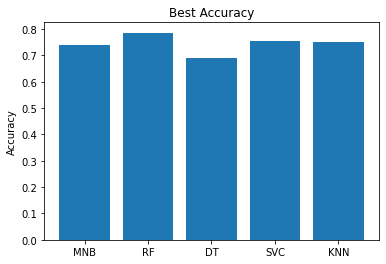

In [ ]:
objects = ('MNB','RF','DT','SVC','KNN')

performance = [acc1,acc2,acc3,acc4,acc5]

plt.bar(objects, performance)

plt.ylabel('Accuracy')
plt.title('Best Accuracy')

plt.show()

# RNN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.2)

In [ ]:
max_words = 10000
max_len = 500
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 50)           500000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
127/127 [==============================] - 84s 644ms/step - loss: 0.4572 - accuracy: 0.7776 - val_loss: 0.3363 - val_accuracy: 0.8515


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

158/158 [==============================] - 10s 63ms/step - loss: 0.3340 - accuracy: 0.8533


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.334
  Accuracy: 0.853


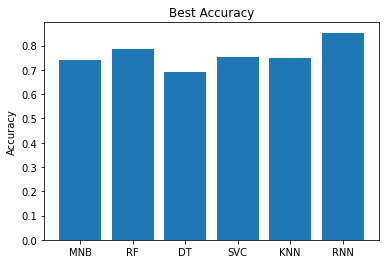

In [ ]:
objects = ('MNB','RF','DT','SVC','KNN','RNN')

performance = [acc1,acc2,acc3,acc4,acc5,accr[1]]

plt.bar(objects, performance)

plt.ylabel('Accuracy')
plt.title('Best Accuracy')

plt.show()